# CENG403 - Spring 2024 - THE3

# Task 2: CNN with PyTorch
In this task, you will implement a convolutional neural network (CNN) with PyTorch.


## 2.1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [1]:
# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary
import numpy as np

## 2.2 Enable GPU

First, under "Edit -> Notebook Settings -> Hardware accelerator", select a GPU. With the following, we will inform PyTorch that we want to use the GPU.

In [2]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:28<00:00, 6033149.06it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 2.3 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset.

### 2.3.1 Visualize Samples

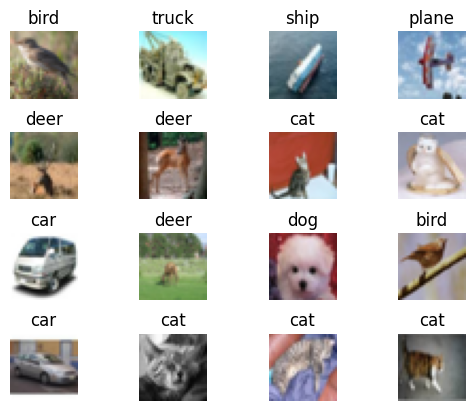

In [4]:
import matplotlib.pyplot as plt


dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = next(dataiter)
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 2.4 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 2.4.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels |
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size |
| ----| -----| ----|
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 |

You should choose suitable values for variables marked with `?' in the table and make sure that receptive fields can be properly placed in all layers.

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import random

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)

        # Calculate the output size after the conv layers and max pooling
        # Conv1: 32x32 -> 28x28 (5x5 kernel, stride 1, padding 0)
        # Conv2: 28x28 -> 26x26 (3x3 kernel, stride 1, padding 0)
        # Maxpool: 26x26 -> 12x12 (4x4 kernel, stride 2, padding 0)
        # Conv3: 12x12 -> 10x10 (3x3 kernel, stride 1, padding 0)
        self.fc1 = nn.Linear(in_features=32 * 10 * 10, out_features=1500)
        self.fc2 = nn.Linear(in_features=1500, out_features=10)

    def forward(self, x):
        # forward pass through convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))

        print("Shape after conv layers:", x.shape)

        # flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        print("Shape after flattening:", x.shape)

        # forward pass through fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


### 2.4.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [6]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
    """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
    """
    loss_history = []
    for epoch in range(epochs):
        for i, data in enumerate(dataloader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zzro the gradients
            optimizer.zero_grad()

            # obtain the scores
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # backpropagate
            loss.backward()

            # update the weights
            optimizer.step()

            loss_history.append(loss.item())

        if verbose:
            print(f'Epoch {epoch + 1} / {epochs}: avg. loss of last 5 iterations {np.mean(loss_history[-5:])}')

    return loss_history


### 2.4.3 Create and visualize the model

In [7]:
import random

# Create an instance of the model and move it to the appropriate device
model = SmallCNN().to(device)

# Summarize the model
summary(model, input_size=(batch_size, 3, 32, 32))


Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])


Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         1,216
├─Conv2d: 1-2                            [128, 32, 26, 26]         4,640
├─MaxPool2d: 1-3                         [128, 32, 12, 12]         --
├─Conv2d: 1-4                            [128, 32, 10, 10]         9,248
├─Linear: 1-5                            [128, 1500]               4,801,500
├─Linear: 1-6                            [128, 10]                 15,010
Total params: 4,831,614
Trainable params: 4,831,614
Non-trainable params: 0
Total mult-adds (G): 1.26
Input size (MB): 1.57
Forward/backward pass size (MB): 39.82
Params size (MB): 19.33
Estimated Total Size (MB): 60.72

### 2.4.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [8]:
import random
import torch.optim as optim

# Create an instance of the model and move it to the appropriate device
model = SmallCNN().to(device)

# Summarize the model
summary(model, input_size=(batch_size, 3, 32, 32))

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)


Streaming output truncated to the last 5000 lines.
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening

### 2.4.5 The Loss Curve

Let us visualize the loss curve.

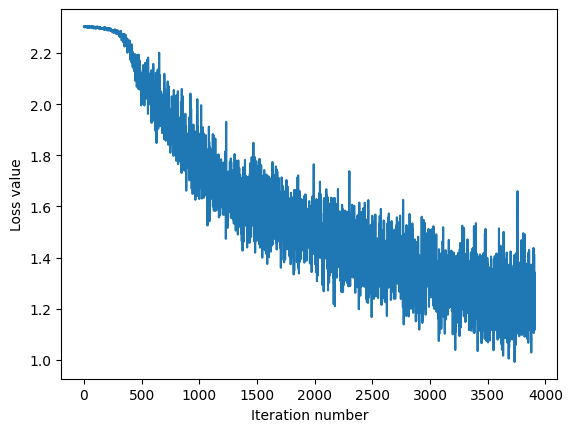

In [9]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.4.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [10]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flattening: torch.Size([128, 3200])
Shape after conv layers: torch.Size([128, 32, 10, 10])
Shape after flatte

## 2.5 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Other than that, there is no restriction on what you can use in your CNN or how you can structure it.


### 2.5.1 Model Definition

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import random

class YourCNN(nn.Module):
    def __init__(self):
        super(YourCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)

        # Define convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        # define max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # define fully connected layers with dropout
        self.fc1 = nn.Linear(in_features=256 * 4 * 4, out_features=512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)

        # flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# Create an instance of the model
model = YourCNN()

# Move the model to the appropriate device
model.to(device)

# Summarize the model
summary(model, input_size=(batch_size, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─BatchNorm2d: 1-2                       [128, 32, 32, 32]         64
├─Conv2d: 1-3                            [128, 64, 32, 32]         18,496
├─BatchNorm2d: 1-4                       [128, 64, 32, 32]         128
├─MaxPool2d: 1-5                         [128, 64, 16, 16]         --
├─Conv2d: 1-6                            [128, 128, 16, 16]        73,856
├─BatchNorm2d: 1-7                       [128, 128, 16, 16]        256
├─Conv2d: 1-8                            [128, 256, 16, 16]        295,168
├─BatchNorm2d: 1-9                       [128, 256, 16, 16]        512
├─MaxPool2d: 1-10                        [128, 256, 8, 8]          --
├─Conv2d: 1-11                           [128, 256, 8, 8]          590,080
├─BatchNorm2d: 1-12                      [128, 256, 8, 8]      

### 2.5.2 Create and visuale your model

In [12]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─BatchNorm2d: 1-2                       [128, 32, 32, 32]         64
├─Conv2d: 1-3                            [128, 64, 32, 32]         18,496
├─BatchNorm2d: 1-4                       [128, 64, 32, 32]         128
├─MaxPool2d: 1-5                         [128, 64, 16, 16]         --
├─Conv2d: 1-6                            [128, 128, 16, 16]        73,856
├─BatchNorm2d: 1-7                       [128, 128, 16, 16]        256
├─Conv2d: 1-8                            [128, 256, 16, 16]        295,168
├─BatchNorm2d: 1-9                       [128, 256, 16, 16]        512
├─MaxPool2d: 1-10                        [128, 256, 8, 8]          --
├─Conv2d: 1-11                           [128, 256, 8, 8]          590,080
├─BatchNorm2d: 1-12                      [128, 256, 8, 8]      

### 2.5.3 Train the Model

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 1 / 10: avg. loss of last 5 iterations 1.6024125337600708
Epoch 2 / 10: avg. loss of last 5 iterations 1.2285471439361573
Epoch 3 / 10: avg. loss of last 5 iterations 1.1492893934249877
Epoch 4 / 10: avg. loss of last 5 iterations 0.9533834338188172
Epoch 5 / 10: avg. loss of last 5 iterations 0.8810887694358825
Epoch 6 / 10: avg. loss of last 5 iterations 0.8094906449317932
Epoch 7 / 10: avg. loss of last 5 iterations 0.6911238670349121
Epoch 8 / 10: avg. loss of last 5 iterations 0.6999046683311463
Epoch 9 / 10: avg. loss of last 5 iterations 0.5939689397811889
Epoch 10 / 10: avg. loss of last 5 iterations 0.5700943946838379


### 2.5.4 Loss Curve

Let us visualize the loss curve.

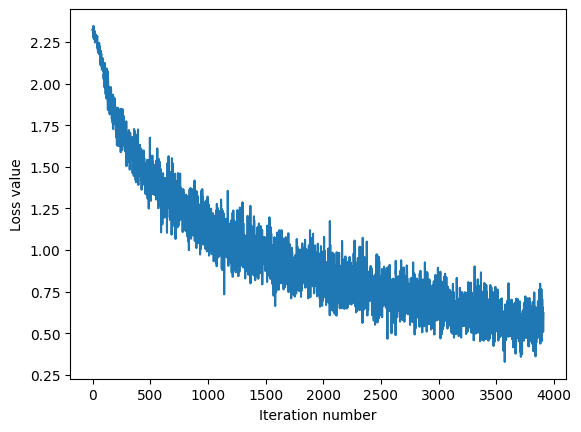

In [14]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.5.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [15]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %
